# Titanic: Machine Learning from Disaster

Predict survival on the Titanic and get familiar with ML basics.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

In [2]:
TRAIN_FILEPATH = "./data/train.csv"

In [3]:
df = pd.read_csv(TRAIN_FILEPATH)

## Data Dictionary

| Variable | Definition | Key |
|----------|------------|-----|                       
| Survival | Survival   | 0 = No, 1 = Yes |
| Pclass   | Ticket     | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex      | Sex        |     |
| Age      | Age in years |   |
| Sibsp    | Number of siblings or spouses aboard |
| Parch    | Number of parents or children aboard |
| Ticket   | Ticket number |  |
| Fare     | Passenger fare | |
| Cabin    | Cabin number  |  |
| Embarked | Port of Embarkation| C = Cherbourg, Q = Queenstown, S = Southampton |


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Data Cleaning

The DataFrame info shows that the following columns contain Null values:

1. Age with 177 null values
2. Cabin with 687 null values
3. Embarked with null values

Out of the 3 columns I belive Age is more import than which cabin number the passengers are in or where they embarked from.

Now 177 null values is a significant number they cannot be ignore by assuming it doesnt exist. To fill forward or backwards method for age would be a correct approach because its not in laid out in a timeseries manner that the order matters.

A good approach might be to fill the null values with either mean values or median.

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Fill Missing Age Values 

In [7]:
age_mean = df["Age"].mean()
age_median = df["Age"].median()
age_max = df["Age"].max()
age_min = df["Age"].min()

print("Mean Age Value: {}".format(age_mean))
print("Median Age Value: {}".format(age_median))
print("Max Age Value: {}".format(age_max))
print("Min Age Value: {}".format(age_min))

Mean Age Value: 29.69911764705882
Median Age Value: 28.0
Max Age Value: 80.0
Min Age Value: 0.42


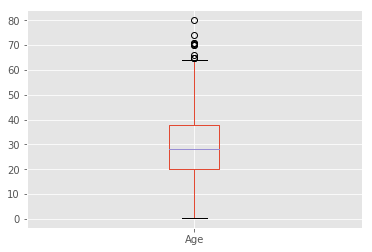

In [8]:
df.boxplot("Age")

With the mean and median very close to each other that means the data is near evenly distributed. With the boxplot it shows some outliers in the data which may contribute to a slightly higher mean.

In the case of filling missing values I would choose mean.

In [9]:
df["Age"].fillna(value=df["Age"].mean(), inplace=True)

df.info()  # To check if all the null values for age is filled in.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Filling Missing Embarked Value

In [10]:
embarked_df = df[df["Embarked"].isnull()]
embarked_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Finding Someone living in the same Cabin or holding the same ticket number will provide us with information that can tell where they embarked from.

In [11]:
df[(df['Embarked'].notnull()) & ((df['Ticket'] == '113572') | (df['Cabin'] == 'B28'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Because this yielding no results, I will fill the missing values with the Embarked Values which has occured the most.

In [12]:
print("Embarked from: \nCherbourg, C: {}\nQueenstown, Q: {}\nSouthampton, S: {}".format(len(df[df["Embarked"] == "C"]),
                                                                                       len(df[df["Embarked"] == "Q"]),
                                                                                       len(df[df["Embarked"] == "S"])))

Embarked from: 
Cherbourg, C: 168
Queenstown, Q: 77
Southampton, S: 644


In [13]:
df["Embarked"].fillna(value="S", inplace=True)

df.info()  # To check if all the null values for embarked is filled in.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Remove un-wanted columns

In [14]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The following columns add no value, PassengerId, Name, Ticket, Cabin.

Just an id 1 to 891 holding no values for future prediction,

In [15]:
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1, inplace=True)

In [24]:
df['Embarked'] = df['Embarked'].map({'C': 1, 'Q': 2, 'S':3})
df['Sex'] = df['Sex'].map({'female': 1, 'Q': 2, 'S':3})

In [25]:
df.head()  # Check if columns have been removed

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,3
1,1,1,female,38.0,1,0,71.2833,1
2,1,3,female,26.0,0,0,7.9250,3
3,1,1,female,35.0,1,0,53.1000,3
4,0,3,male,35.0,0,0,8.0500,3


## Exploring Data

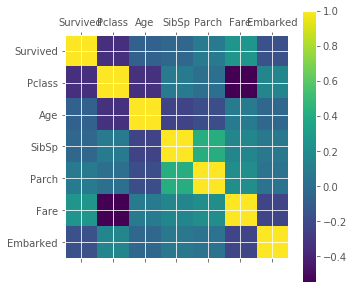

In [26]:
size = 5
corr = df.corr()
fig, ax = plt.subplots(figsize=(size, size))
fig.colorbar(ax.matshow(corr))
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

What I am interest in is the correlation between different columns vs Survived, a higher correclation mean more change of survival.

I believe there would be a strong correlation for survived with Fare, Pclass. Which seems to be true as a higher Pclass means 3rd class ticket, so holding a 1st class ticket will have a stronger change of surviving. Which again holds same correlation with Fare and Pclass. 1st class pays a higher fare.

## Machine Learning

Split the data in X (input) and y (output) layout.

In [27]:
X = df.copy()
y = X["Survived"]

In [28]:
#X.head()  # Print to check columns
y.head()  # Print to check columns

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Shuffle and split the data into a training and validation set.

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Checking the size of train_test_split, just for confirmation
print("Size of X: {}, Size of y: {}".format(len(X), len(y)))
print("Size of X_train: {}, Size of y_train: {}".format(len(X_train), len(y_train)))
print("Size of X_val: {}, Size of y_val: {}".format(len(X_val), len(y_val)))

Size of X: 891, Size of y: 891
Size of X_train: 712, Size of y_train: 712
Size of X_val: 179, Size of y_val: 179


In [31]:
#for i in range(6):
#    print(y_train[i] == 'S')

y_train.head(10)

331    0
733    0
382    0
704    0
813    0
118    0
536    0
361    0
29     0
55     1
Name: Survived, dtype: int64

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

predictions = lr.predict(X_val)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, predictions)

print(accuracy)

ValueError: could not convert string to float: 'male'

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_val)

print(predictions)
